# Basics of using generalized code to make a donut plot with subgroups

This just covers the basics to remake [the example from The Python Graph Gallery](https://python-graph-gallery.com/163-donut-plot-with-subgroups/) shown below. Let's make something very similar to this:


![plot example](https://python-graph-gallery.com/wp-content/uploads/163_Double_Donut_Chart.png)


A more full-featured script that makes a similar plot from the same data **without further need for coding** that allows you to plug in your own data input is demonstrated in [this notebook](index.ipynb). Click back to [that page](index.ipynb) if you want the fastest route to a donut plot that you can easily customize. Or go to the following in the series if you want related full-featured scripts and aren't interesting in the coding behind it.

- [Demonstrate a full-featured script that plots a summary for the subgroups in addition to the donut plot with subgroups](??????)
- [Demonstrate a full-featured script that plots a summary for binary data in addition to the donut plot with the binary group broken down by a group](??????)

----

## Preparation

A dataframe will be used for input data. The following code will define it.

In [1]:
import pandas as pd
obs = [('A', 1, "frizzled"), 
       ('A', 1, "lethargic"), 
       ('A', 1, "polythene"), 
       ('A', 1, "epic"),
       ('A', 2, "frizzled"), 
       ('A', 2, "lethargic"), 
       ('A', 2, "epic"),
       ('A', 3, "frizzled"), 
       ('A', 3, "lethargic"),
       ('A', 3, "polythene"),
       ('A', 3, "epic"),
       ('A', 3, "bedraggled"),
       ('B', 1, "frizzled"), 
       ('B', 1, "lethargic"),
       ('B', 1, "polythene"),
       ('B', 1, "epic"),
       ('B', 1, "bedraggled"),
       ('B', 1, "moombahcored"),
       ('B', 2, "frizzled"), 
       ('B', 2, "lethargic"),
       ('B', 2, "polythene"),
       ('B', 2, "epic"),
       ('B', 2, "bedraggled"),
       ('C', 1, "frizzled"), 
       ('C', 1, "lethargic"),
       ('C', 1, "polythene"),
       ('C', 1, "epic"),
       ('C', 1, "bedraggled"),
       ('C', 1, "moombahcored"),
       ('C', 1, "zoned"),
       ('C', 1, "erstaz"),
       ('C', 1, "mined"),
       ('C', 1, "liberated"),
       ('C', 2, "frizzled"), 
       ('C', 2, "lethargic"),
       ('C', 2, "polythene"),
       ('C', 2, "epic"),
       ('C', 2, "bedraggled"),
       ('C', 3, "frizzled"), 
       ('C', 3, "lethargic"),
       ('C', 3, "polythene"),
       ('C', 3, "epic"),
       ('C', 3, "bedraggled"),
       ('C', 4, "bedraggled"),
       ('C', 4, "frizzled"), 
       ('C', 4, "lethargic"),
       ('C', 4, "polythene"),
       ('C', 4, "epic"),
       ('C', 5, "frizzled"), 
       ('C', 5, "lethargic"),
       ('C', 5, "polythene"),
       ('C', 5, "epic"),
       ('C', 5, "bedraggled"),
       ('C', 5, "moombahcored")]
labels = ['group', 'subgroup', 'sub-subgroup']
df = pd.DataFrame.from_records(obs, columns=labels)
df.head()

,group,subgroup,sub-subgroup
0,A,1,frizzled
1,A,1,lethargic
2,A,1,polythene
3,A,1,epic
4,A,2,frizzled


To illustrate that this can work with tabular text data, let's save that as tab-separated text, like something you can easily generate from data in Excel or Google sheets, too.

In [2]:
df.to_csv('data.tsv', sep='\t',index = False) 

To verify this is just text:

In [3]:
!head data.tsv

group	subgroup	sub-subgroup
A	1	frizzled
A	1	lethargic
A	1	polythene
A	1	epic
A	2	frizzled
A	2	lethargic
A	2	epic
A	3	frizzled
A	3	lethargic


Now let's use that data to make something very similar to [the example from The Python Graph Gallery](https://python-graph-gallery.com/163-donut-plot-with-subgroups/) shown above.

First we need to define some helper functions that the original one didn't have in order to help generalize thus current version.

In [4]:
## helper functions and settings
import sys
import os
try:
    from pathlib import Path
except ImportError:
    from pathlib2 import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plot_figure_size = (7,8) # width by height written as `(width,height)`; 
# If you change this to substantial degree, you may also want to 
# adjust text size settings below and possibly turn off plot titles using 
# `include_title=False`in favor of adding your own in post-processing.
outer_ring_radius = 1.3 # radius of the outer ring of the donut plot
inner_ring_radius = outer_ring_radius-0.3 # radius of the inner ring of donut
outer_ring_width=0.3
inner_ring_width=0.4
include_title = True
plot_title = "BREAKDOWN"
title_text_size = 20     # font size for title above plot
plot_text_size = 14 # font size for text in the plot
large_img_size = (14,15) # size to be used with `--large_image` `flag. Width 
# by height written as `(width,height)`
light_color_for_last_in_subgroup = True # Set this to False to reverse the 
# order of the subgroup coloring.
save_plot_name_prefix = "donut_plot"
def sequential_color_maps_generator():
    '''
    generator to yield a never-ending supply of sequential color palettes/ 
    color maps.
    '''
    color_brewer_seq_names = ["Blues", "Reds","Greens","Oranges",
                            "Purples"] #"Greys" looks bad because white is least
    list_of_other_good_sequences = ["teal", "fuchsia", "darkslateblue", "sage", 
                                    "darkviolet",  "crimson", "darkgoldenrod", 
                                    "dodgerblue", "maroon", "darkolivegreen",  
                                    "darkturquoise", "royalblue", "chocolate"]
    np.random.seed(42)
    for col_name in color_brewer_seq_names:
        yield plt.get_cmap(col_name) #`plt.get_cmap` use based on
        # https://matplotlib.org/tutorials/colors/colormaps.html
    for col_name in list_of_other_good_sequences:
        try:
            yield sns.light_palette(col_name, as_cmap=True)
        except ValueError:
            yield sns.light_palette(col_name, as_cmap=True,input="xkcd")
    while True:
        rgb = tuple((np.random.random(size=3) * 1)) # based on 
        # https://stackoverflow.com/a/48793922/8508004
        yield sns.light_palette(rgb, input="rgb", as_cmap=True)
def extract_dataframe(file_name):
    '''
    Takes a file name and using the extension determines how to extract the
    dataframe recorded in it. 
    Returns a pandas dataframe object.
    '''
    extension = Path(file_name).suffix
    if extension.lower() == ".pkl":
        return pd.read_pickle(file_name)
    elif extension.lower() == ".tsv":
        return pd.read_csv(file_name, sep='\t')
    elif extension.lower() == ".csv":
        return pd.read_csv(file_name)
    else:
        sys.stderr.write("\n**ERROR** Cannot determine how dataframe is stored "
            "in '{}'.\nChange the file name extension in the input file to be "
            "`.pkl`, `.tsv`, or `.csv` to indicate\nif dataframe stored "
            "pickled, stored as tab-separated text, or stored as\n"
            "comma-separated text."
            ".\n**EXITING !!**.\n".format(file_name))
        sys.exit(1)
def is_number(s):
    '''
    check if a string can be cast to a float or numeric (integer).
    fixed from https://www.pythoncentral.io/how-to-check-if-a-string-is-a-number-in-python-including-unicode/
    later noted similar code is at https://code-maven.com/slides/python-programming/is-number
    '''
    try:
        float(s)
        return True
    except ValueError:
        pass
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
    return False

def cast_to_number(s):
    '''
    Cast a string to a float or integer. 
    based on fixed code from https://www.pythoncentral.io/how-to-check-if-a-string-is-a-number-in-python-including-unicode/
    '''
    try:
        number = float(s)
        try:
            number = int(s)
            return number
        except ValueError:
            pass
        return number
    except ValueError:
        pass
    try:
        import unicodedata
        num = unicodedata.numeric(s)
        return num
    except (TypeError, ValueError):
        pass
    return False

def f7(seq):
    '''
    remove duplicates from a list whilst preserving order.
    from https://stackoverflow.com/a/480227/8508004
    '''
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

Now to convert the core of the example script:

In [5]:
def donut_plot_with_subgroups_from_dataframe(
    df_file=None, df=None, groups_col=None, subgroups_col=None,
    hilolist = None, 
    sort_on_subgroup_name=False, advance_color_increments=0, 
    include_title=include_title):
    '''
    Takes a dataframe either as a file or passed directly along some information 
    about columns in the dataframe and makes a donut plot.  The plot is a 
    breakdown of the main groups to subgroups with the main groups in an outer
    ring of the dount plot and the subgroups on the inner ring. The style sought 
    is seen at https://python-graph-gallery.com/163-donut-plot-with-subgroups/ .
    '''
    if df is None:
        # use file extension to decide how to parse dataframe file.
        df = extract_dataframe(df_file)

    # Prepare derivatives of the dataframe that may be needed for delineating 
    # the plotting data
    tc = df[subgroups_col].value_counts()
    total_state_names = tc.index.tolist()
    total_state_size = tc.tolist()
    grouped = df.groupby(groups_col)
    # use `value_counts()` on each group to get the count and name of each state
    list_o_subgroup_names_l = []
    list_o_subgroup_size_l = []
    subgroups_per_group_l = []
    for name,group in grouped:
        dfc = group[subgroups_col].value_counts()
        if sort_on_subgroup_name:
            dfc = group[subgroups_col].value_counts().sort_index()
        #list_o_subgroup_names_l.append(dfc.index.tolist())
        # to make the subgroup names like in the example, incorporate
        # group name to each as well
        list_o_subgroup_names_l.append(["{}.{}".format(name,x) for x in dfc.index.tolist()])
        list_o_subgroup_size_l.append(dfc.tolist())
        subgroups_per_group_l.append(f7(group[subgroups_col].tolist()))
    
    # Delineate data for the plot:
    group_names= grouped.size().index.tolist()
    group_size= grouped.size().tolist() #len of each groupby grouping
    # flatten each list of lists made above to get the list needed
    subgroup_names=[i for sublt in list_o_subgroup_names_l for i in sublt]
    subgroup_size=[i for sublt in list_o_subgroup_size_l for i in sublt]
    assert len(subgroup_size) == len(subgroup_names)

    # Create colors generator and colors
    colormp = sequential_color_maps_generator()
    [next(colormp) for g in range(advance_color_increments)]#advance prior to 
    # use, if initial skips specified
    colorm_per_grp=[next(colormp) for g in group_names]

    #Set up for plot.
    fig, ax = plt.subplots(figsize=plot_figure_size)
    ax.axis('equal')

    ### First Ring (outside)
    ### This will be the main groups
    labels_with_grp_sz = ["group{}".format(
            x) for x, y in zip(group_names, group_size)]
    mypie, _ = plt.pie(
        group_size, radius=outer_ring_radius, labels=labels_with_grp_sz, 
        textprops={'fontsize': plot_text_size},
        colors=[colormp(0.63) for colormp in colorm_per_grp] )
    plt.setp( mypie, width=outer_ring_width, edgecolor='white')
     
    ### Second Ring (Inside)
    ### This will be the subgroup counting for each group
    list_sub_grp_colors_l  = []
    subgroups_represented = f7(df[subgroups_col].tolist())
    #int_degree = [0.6,0.2]
    if hilolist:
        assert len(hilolist) == len(subgroups_represented), "The list provided "
        "to specify the intensity degree must include all subgroups. Subgroups "
        "are: '{}'.format(subgroups_represented)"
        subgroups_represented = hilolist
    else:
        # Provide feedback on what is being used as high to low intensity list 
        # so user can adjust; using `if __name__ == "__main__"` to customize 
        # note depending if script called from command line.
        sys.stderr.write("Note:No list to specify high to low intensity coloring "
            "provided and so using '{}',\nwhere leftmost identifer corresponds "
            "to most intense and rightmost is least.\n".format(
            ",".join(str(i) for i in subgroups_represented))) # because subgroups 
        # could be integers as in example from 
        # https://python-graph-gallery.com/163-donut-plot-with-subgroups/, best 
        # to have conversion to string,
        if __name__ == "__main__":
            sys.stderr.write("Look into adding use of the `--hilolist` opition "
                "to specify the order.\n\n")
        else:
            sys.stderr.write("Provide a Python list as `hilolist` when calling "
                "the function to specify the order.\n\n")
    # assign intensity degree settings for each subgroup so consistent among 
    # other groups
    int_degree = np.linspace(0.6, 0.2, num=len(subgroups_represented))
    if not light_color_for_last_in_subgroup:
        int_degree.reverse()
    # determine colors for each subgroup before `plt.pie` step
    for idx,subgroups_l in enumerate(subgroups_per_group_l):
        cm = colorm_per_grp[idx]
        grp_colors = [cm(int_degree[subgroups_represented.index(
            sgrp)]) for sgrp in subgroups_l]
        list_sub_grp_colors_l.append(grp_colors)
    # flatten that list
    sub_grp_colors = [i for sublt in list_sub_grp_colors_l for i in sublt]
    mypie2, _ = plt.pie(
        subgroup_size, radius=inner_ring_radius, labels=subgroup_names, 
        textprops={'fontsize': plot_text_size}, labeldistance=0.7, 
        colors=sub_grp_colors)
    plt.setp( mypie2, width=inner_ring_width, edgecolor='white')
    plt.margins(0,0)
    if include_title:
        plt.title(plot_title, size = title_text_size)

    return ax

Note:No list to specify high to low intensity coloring provided and so using '1,2,3,4,5',
where leftmost identifer corresponds to most intense and rightmost is least.
Look into adding use of the `--hilolist` opition to specify the order.



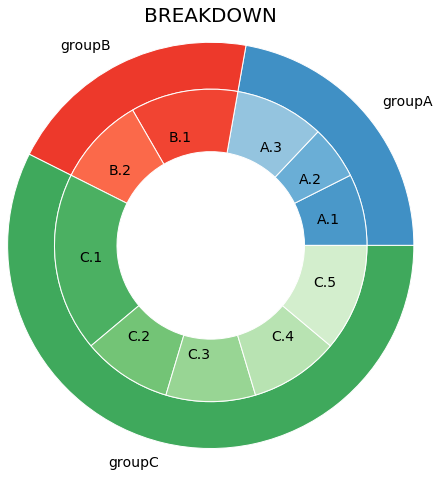

In [6]:
a = donut_plot_with_subgroups_from_dataframe(df_file="data.tsv", groups_col="group",subgroups_col ="subgroup",sort_on_subgroup_name=True);

Note we could have also used the dataframe object made in the first cell as the object to act on. The file form of tabular text was used originally as it would be something more people may have and can make.

So instead of `df_file`, now we provide `df` and indicate the dataframe to use.

Note:No list to specify high to low intensity coloring provided and so using '1,2,3,4,5',
where leftmost identifer corresponds to most intense and rightmost is least.
Look into adding use of the `--hilolist` opition to specify the order.



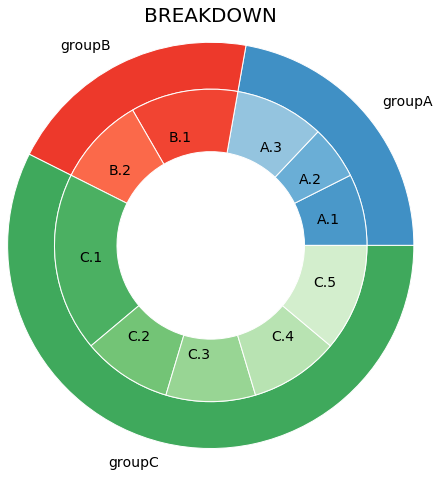

In [7]:
b = donut_plot_with_subgroups_from_dataframe(df=df, groups_col="group",subgroups_col ="subgroup",sort_on_subgroup_name=True);

In [8]:
import time

def executeSomething():
    #code here
    print ('.')
    time.sleep(480) #60 seconds times 8 minutes

while True:
    executeSomething()

.


KeyboardInterrupt: 

**NOTE:**  
In [the example from The Python Graph Gallery](https://python-graph-gallery.com/163-donut-plot-with-subgroups/) shown below the ordering of the subgroups is based on the name of the subgroups.

----

![plot example](https://python-graph-gallery.com/wp-content/uploads/163_Double_Donut_Chart.png)

----

To get ordering like in the example, the function is called with the `sort_on_subgroup_name` set to `True`. That isn't the default.

This is the default where the subgroups are ordered by size:

Note:No list to specify high to low intensity coloring provided and so using '1,2,3,4,5',
where leftmost identifer corresponds to most intense and rightmost is least.
Look into adding use of the `--hilolist` opition to specify the order.



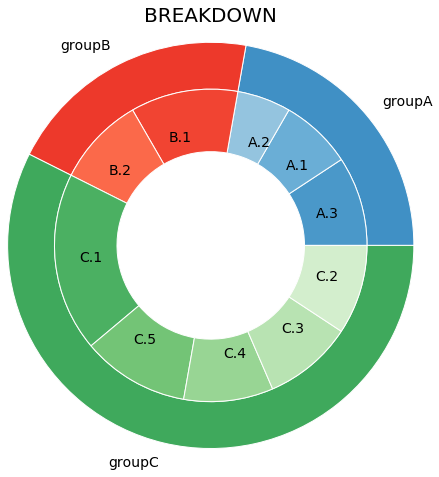

In [9]:
c = donut_plot_with_subgroups_from_dataframe(df=df, groups_col="group",subgroups_col ="subgroup");

----

----

Go to the following pages in the series if you want related full-featured scripts that add summary subplots on the left, along with the donut plots with subgroups on the right.

- [Demonstrate a full-featured script that plots a summary for the subgroups in addition to the donut plot with subgroups](??????)
- [Demonstrate a full-featured script that plots a summary for binary data in addition to the donut plot with the binary group broken down by a group](??????)

Go back to [the first page in the series]((index.ipynb) if you want a full-featured script that provides the fastest route to a donut plot that you can easily customize.

----


----